In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os
from PIL import Image
import sklearn 

In [2]:
def load_dataset(path, target_size=(48, 48)):
    images = []
    labels = []
    
    for emotion_folder in os.listdir(path):
        emotion_path = os.path.join(path, emotion_folder)
        
        if os.path.isdir(emotion_path):
            for image_file in os.listdir(emotion_path):
                image_path = os.path.join(emotion_path, image_file)
                
                # Open the image using PIL and resize it
                img = Image.open(image_path).resize(target_size)
                
                # Convert image to numpy array, normalize pixel values, and add channel dimension
                img_array = np.expand_dims(np.array(img) / 255.0, axis=-1 if img.mode == 'L' else -1)
                
                # Append the image and its label to the lists
                images.append(img_array)
                labels.append(emotion_folder)
    
    return np.array(images), np.array(labels)

In [3]:
dataset_path = 'archive'
training_path = os.path.join(dataset_path, 'train')
testing_path = os.path.join(dataset_path, 'test')

# Assuming your images should be resized to (48, 48)
target_size = (48, 48)
training_images, training_labels = load_dataset(training_path, target_size=target_size)
testing_images, testing_labels = load_dataset(testing_path, target_size=target_size)

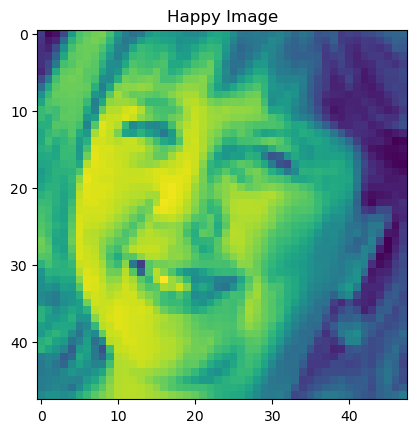

In [4]:
sample_image_path = os.path.join(training_path, 'happy', 'im5776.png')
sample_img = Image.open(sample_image_path)


plt.imshow(sample_img)
plt.title('Happy Image')
plt.show()

In [5]:
label_to_index = {label: index for index, label in enumerate(np.unique(training_labels))}
training_labels = np.array([label_to_index[label] for label in training_labels])

testing_labels = np.array([label_to_index[label] for label in testing_labels])

input_shape = (*target_size, 1 if training_images.shape[-1] == 1 else 3)


In [18]:
model = models.Sequential([
    layers.Conv2D(128, (3,3) , activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3) , activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),
#     layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(16, activation='relu'),
#     layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(len(label_to_index), activation='softmax')])

model.compile(optimizer='adam' ,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],)

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',  
    patience=1,  
    restore_best_weights=True,
    min_delta=.0001)


model.fit(training_images, training_labels, epochs=10, validation_data=(testing_images, testing_labels),callbacks=[early_stopping])

Epoch 1/10
898/898 [==============================] - 46s 51ms/step - loss: 1.7598 - accuracy: 0.3155 - val_loss: 2.0094 - val_accuracy: 0.2098
Epoch 2/10
898/898 [==============================] - 46s 51ms/step - loss: 1.4639 - accuracy: 0.4342 - val_loss: 1.4161 - val_accuracy: 0.4515
Epoch 3/10
898/898 [==============================] - 45s 50ms/step - loss: 1.3541 - accuracy: 0.4805 - val_loss: 1.3730 - val_accuracy: 0.4772
Epoch 4/10
898/898 [==============================] - 59s 65ms/step - loss: 1.2883 - accuracy: 0.5115 - val_loss: 1.3181 - val_accuracy: 0.4905
Epoch 5/10
898/898 [==============================] - 49s 55ms/step - loss: 1.2347 - accuracy: 0.5336 - val_loss: 1.3054 - val_accuracy: 0.5010
Epoch 6/10
898/898 [==============================] - 47s 52ms/step - loss: 1.1938 - accuracy: 0.5485 - val_loss: 1.2914 - val_accuracy: 0.5162
Epoch 7/10
898/898 [==============================] - 51s 57ms/step - loss: 1.1615 - accuracy: 0.5612 - val_loss: 1.3097 - val_accuracy:

In [19]:
_, accuracy = model.evaluate(testing_images, testing_labels)
print(f"Accuracy on testing data: {accuracy * 100:.2f}%")

225/225 [==============================] - 3s 12ms/step - loss: 1.2914 - accuracy: 0.5162
Accuracy on testing data: 51.62%


In [20]:
from PIL import Image

def preprocess_image(image_path, target_size=(48, 48), grayscale=True):

    img = Image.open(image_path)

    if grayscale and img.mode != 'L':
        img = img.convert('L')

    img = img.resize(target_size)

    img_array = np.expand_dims(np.array(img) / 255.0, axis=-1 if grayscale else -1)

    return img_array
 
local_image_path = 'UNKNOWN.jpeg' #Happy
 

input_image = preprocess_image(local_image_path)

predictions = model.predict(np.array([input_image]))


predicted_label = np.argmax(predictions[0])

index_to_label = {index: label for label, index in label_to_index.items()}

predicted_emotion = index_to_label[predicted_label]

print(f"Predicted emotion: {predicted_emotion}")


1/1 [==============================] - 0s 67ms/step
Predicted emotion: happy


In [21]:
local_image_path = '347901832.jpg'  #sad 


input_image = preprocess_image(local_image_path)

predictions = model.predict(np.array([input_image]))


predicted_label = np.argmax(predictions[0])

index_to_label = {index: label for label, index in label_to_index.items()}

predicted_emotion = index_to_label[predicted_label]

print(f"Predicted emotion: {predicted_emotion}")

1/1 [==============================] - 0s 11ms/step
Predicted emotion: angry


In [22]:
local_image_path = '56831e52417cc9f8aa9ee634739fd7d2.jpg'  #angry


input_image = preprocess_image(local_image_path)

predictions = model.predict(np.array([input_image]))


predicted_label = np.argmax(predictions[0])

index_to_label = {index: label for label, index in label_to_index.items()}
predicted_emotion = index_to_label[predicted_label]

print(f"Predicted emotion: {predicted_emotion}")

1/1 [==============================] - 0s 15ms/step
Predicted emotion: angry


In [101]:
label_to_index

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}